<a href="https://www.kaggle.com/code/priyanagda/getting-started-understanding-data?scriptVersionId=95967966" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## This Notebook is for visualizing and understanding the data available.

## Work is still in progress.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
import tqdm
import cv2

In [2]:
train_data = pd.read_csv('../input/uw-madison-gi-tract-image-segmentation/train.csv')

In [3]:
train_data.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
train_images = glob('../input/uw-madison-gi-tract-image-segmentation/train/*/*/*/*')

In [5]:
len(train_images)

38496

In [6]:
train_images[0]

'../input/uw-madison-gi-tract-image-segmentation/train/case36/case36_day14/scans/slice_0006_266_266_1.50_1.50.png'

**Each case has 144 scans, with a few being segmentation masks.
It is to be noted that not all cases have masks**

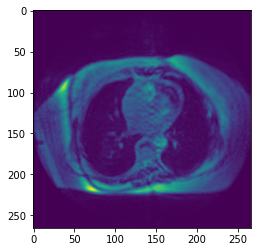

In [7]:
image = cv2.imread(train_images[0], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

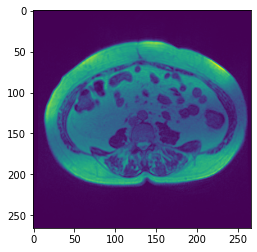

In [8]:
image = cv2.imread(train_images[143], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

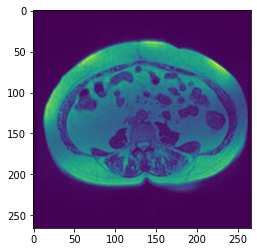

In [9]:
image = cv2.imread(train_images[1], cv2.IMREAD_UNCHANGED)
plt.imshow(image)

The segmentation (where doesn't have the value nan) is formed by a list of numbers containing different pixel points and their length. As an example:

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

where:

28094, 28358, 28623 etc. are the startpoints of the pixels within the matrix
and 3, 7, 9, 9 etc. are how long to strech the startpoints - meaning the total length
hence we can compute the endpoint of each of these segments as the sum of startpoints + endpoints

In [10]:
def rle2mask(mask_rle, shape):
    s = mask_rle.split(" ")
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    ends = starts + lengths - 1
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for low, high in zip(starts-1, ends):
        img[low : high] = 1
    return img.reshape(shape).T

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [12]:
train_seg = train_data.dropna()

In [13]:
train_seg.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


In [14]:
train_seg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33913 entries, 194 to 115465
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            33913 non-null  object
 1   class         33913 non-null  object
 2   segmentation  33913 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [15]:
train_seg['segmentation'].iloc[0]

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

In [16]:
mask1 = rle2mask(train_seg['segmentation'].iloc[0], image.shape)

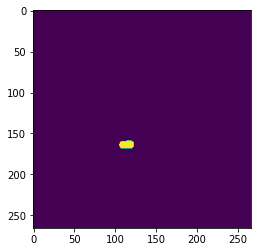

In [17]:
plt.imshow(mask1)

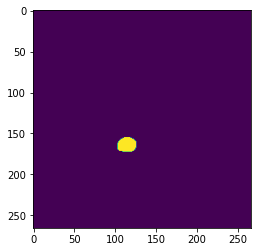

In [18]:
mask2 = rle2mask(train_seg['segmentation'].iloc[1], image.shape)
plt.imshow(mask2)

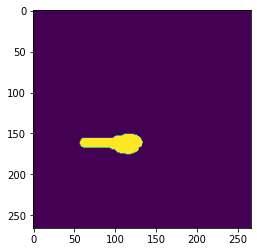

In [19]:
mask3 = rle2mask(train_seg['segmentation'].iloc[2], image.shape)
plt.imshow(mask3)

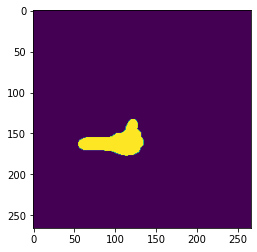

In [20]:
mask4 = rle2mask(train_seg['segmentation'].iloc[3], image.shape)
plt.imshow(mask4)

In [21]:
train_seg['class'].value_counts()

large_bowel    14085
small_bowel    11201
stomach         8627
Name: class, dtype: int64

In [22]:
train_seg[['case', 'day','_', 'slice']] = train_seg['id'].str.split('_', expand=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [23]:
train_seg.drop('_', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [24]:
train_seg.head()

,id,class,segmentation,case,day,slice
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,case123,day20,0065
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,case123,day20,0066
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,case123,day20,0067
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,case123,day20,0068
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,case123,day20,0069


In [25]:
train_seg['case'] = train_seg['case'].str.replace('case', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [26]:
train_seg['day'] = train_seg['day'].str.replace('day', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
train_seg.head()

,id,class,segmentation,case,day,slice
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,123,20,0065
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,123,20,0066
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,123,20,0067
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,123,20,0068
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,123,20,0069


In [28]:
train_data['id'].value_counts()

case123_day20_slice_0001    3
case55_day18_slice_0091     3
case55_day18_slice_0093     3
case55_day18_slice_0094     3
case55_day18_slice_0095     3
                           ..
case49_day13_slice_0049     3
case49_day13_slice_0050     3
case49_day13_slice_0051     3
case49_day13_slice_0052     3
case30_day0_slice_0144      3
Name: id, Length: 38496, dtype: int64

In [29]:
enum = ['stomach', 'large_bowel', 'small_bowel']

In [30]:
unique_ids = train_data['id'].unique()

In [31]:
unique_ids

array(['case123_day20_slice_0001', 'case123_day20_slice_0002',
       'case123_day20_slice_0003', ..., 'case30_day0_slice_0142',
       'case30_day0_slice_0143', 'case30_day0_slice_0144'], dtype=object)

In [32]:
for id in unique_ids:
    idx = train_data[train_data.id == id]
    print(idx)
    break

                         id        class segmentation
0  case123_day20_slice_0001  large_bowel          NaN
1  case123_day20_slice_0001  small_bowel          NaN
2  case123_day20_slice_0001      stomach          NaN


In [63]:
df = pd.DataFrame()
df['id'] = unique_ids
df['stomach_rle'] = pd.Series(dtype='string')
df['large_bowel_rle'] = pd.Series(dtype='string')
df['small_bowel_rle'] = pd.Series(dtype='string')

In [64]:
df.head()

,id,stomach_rle,large_bowel_rle,small_bowel_rle
0,case123_day20_slice_0001,<NA>,<NA>,<NA>
1,case123_day20_slice_0002,<NA>,<NA>,<NA>
2,case123_day20_slice_0003,<NA>,<NA>,<NA>
3,case123_day20_slice_0004,<NA>,<NA>,<NA>
4,case123_day20_slice_0005,<NA>,<NA>,<NA>


In [65]:
for i, id in enumerate(unique_ids):
    idx = train_data[train_data.id == id]
    for index, row in idx.iterrows():
        if row['class'] == 'stomach':
            df.at[i,'stomach_rle'] = row['segmentation']
        elif row['class'] == 'large_bowel':
            df.at[i,'large_bowel_rle'] = row['segmentation']
        elif row['class'] == 'small_bowel':
            df.at[i,'small_bowel_rle'] = row['segmentation']

In [66]:
df

,id,stomach_rle,large_bowel_rle,small_bowel_rle
0,case123_day20_slice_0001,<NA>,<NA>,<NA>
1,case123_day20_slice_0002,<NA>,<NA>,<NA>
2,case123_day20_slice_0003,<NA>,<NA>,<NA>
3,case123_day20_slice_0004,<NA>,<NA>,<NA>
4,case123_day20_slice_0005,<NA>,<NA>,<NA>
...,...,...,...,...
38491,case30_day0_slice_0140,<NA>,<NA>,<NA>
38492,case30_day0_slice_0141,<NA>,<NA>,<NA>
38493,case30_day0_slice_0142,<NA>,<NA>,<NA>
38494,case30_day0_slice_0143,<NA>,<NA>,<NA>


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               38496 non-null  object
 1   stomach_rle      8627 non-null   string
 2   large_bowel_rle  14085 non-null  string
 3   small_bowel_rle  11201 non-null  string
dtypes: object(1), string(3)
memory usage: 1.2+ MB


Above data indicates that most scans don't have masks

Saving the df to csv, as the above code is for readibility purposes and hence not the most efficient code. 

In [71]:
df.to_csv('./data.csv', index=False)